In [34]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

market_features = pd.read_csv(
    "all_features_BTCUSDT.csv", index_col=0, parse_dates=[0], low_memory=False
)
market_features = market_features.resample("D").ffill()
market_features = market_features.loc[:, market_features.isna().mean() <= 0.7]
market_columns = market_features.columns.tolist()

strategies_data = {}
returns_features_path = "returns_features"
for file in os.listdir(returns_features_path):
    if file.endswith("_returns_features.csv"):
        strategy_name = file.replace("_returns_features.csv", "")
        df = pd.read_csv(
            os.path.join(returns_features_path, file),
            index_col=0,
            parse_dates=[0],
            low_memory=False,
        )
        df = df.resample("D").ffill()
        # df['Sharpe_Ratio_Target'] = ((df['Sharpe_Ratio_30'].shift(-1) > 0) | ((df['Sharpe_Ratio_30'].shift(-1) > df['Sharpe_Ratio_30']) & (df['Sharpe_Ratio_30']<0))).astype(int)
        # df['Sharpe_Ratio_Target'] = (df['Log_Returns'].shift(-1) > df['Log_Returns']).astype(int)
        # df['Sharpe_Ratio_Target'] = (df['Mean_Returns_5'].shift(-1) >= df['Mean_Returns_5']).astype(int)
        # test = df[['Sharpe_Ratio_10','Sharpe_Ratio_Target']]

        # df["Sharpe_current_Target_10"] = (
        #     df["Sharpe_Ratio_10"].shift(-1) > df["Sharpe_Ratio_10"]
        # ).astype(int)
        # df["Sharpe_current_Target_30"] = (
        #     df["Sharpe_Ratio_30"].shift(-1) > df["Sharpe_Ratio_30"]
        # ).astype(int)

        # df["Sharpe_0_Target_10"] = (df["Sharpe_Ratio_10"].shift(-1) > 0).astype(int)
        # df["Sharpe_0_Target_30"] = (df["Sharpe_Ratio_30"].shift(-1) > 0).astype(int)

        # df["Sharpe_Mixed_Target_30"] = (
        #     (df["Sharpe_Ratio_30"].shift(-1) > 0)
        #     | (
        #         (df["Sharpe_Ratio_30"].shift(-1) > df["Sharpe_Ratio_30"])
        #         & (df["Sharpe_Ratio_30"] < 0)
        #     )
        # ).astype(int)
        # df["Sharpe_Mixed_Target_10"] = (
        #     (df["Sharpe_Ratio_10"].shift(-1) > 0)
        #     | (
        #         (df["Sharpe_Ratio_10"].shift(-1) > df["Sharpe_Ratio_10"])
        #         & (df["Sharpe_Ratio_10"] < 0)
        #     )
        # ).astype(int)

        df["Mean_Returns_Target"] = (
            df["Mean_Returns_1"].shift(-1) > 0
        ).astype(int)
        df["Mean_Returns_1_Target"] = df["Mean_Returns_1"].shift(-1)

        # df["Mean_Returns_5_Target"] = (
        #     df["Mean_Returns_5"].shift(-1) > df["Mean_Returns_5"]
        # ).astype(int)

        # sharpe_volatility = df["Sharpe_Ratio_30"].diff().rolling(window=5).std()
        # threshold = sharpe_volatility.quantile(0.9)  # Top 10% as high volatility
        # df["High_Sharpe_30_Volatility_Target"] = (
        #     sharpe_volatility.shift(-1) < threshold  # 0 if high volatility, don't trade
        # ).astype(int)

        # sharpe_volatility = df["Sharpe_Ratio_10"].diff().rolling(window=5).std()
        # threshold = sharpe_volatility.quantile(0.9)  # Top 10% as high volatility
        # df["High_Sharpe_10_Volatility_Target"] = (
        #     sharpe_volatility.shift(-1) < threshold
        # ).astype(int)

        df = df[:-1]
        strategies_data[strategy_name] = df

all_targets = [
    # "Sharpe_current_Target_10",
    # "Sharpe_current_Target_30",
    # "Sharpe_0_Target_10",
    # "Sharpe_0_Target_30",
    # "Sharpe_Mixed_Target_30",
    # "Sharpe_Mixed_Target_10",
    # "Mean_Returns_5_Target",
    "Mean_Returns_Target",
    'Mean_Returns_1_Target',
    # "High_Sharpe_10_Volatility_Target",
    # "High_Sharpe_30_Volatility_Target",
]

trues = {
    # "Sharpe_Target_10": "Sharpe_Ratio_10",
    # "Sharpe_Target_30": "Sharpe_Ratio_30",
    "Mean_Returns_Target": "Mean_Returns_1",
    'Mean_Returns_1_Target': 'Mean_Returns_1'
    # "Mean_Returns_5_Target": "Mean_Returns_5",
}

merged_data = {}
for strategy, df in strategies_data.items():
    merged_df = pd.merge(
        market_features, df, left_index=True, right_index=True, how="inner"
    )
    merged_df = merged_df.dropna(axis=1, thresh=0.5 * len(merged_df))
    second_half_index = range(len(merged_df) // 2, len(merged_df))
    columns_to_keep = ["Mean_Returns_1_Target"]

    columns_with_nans_in_second_half = merged_df.iloc[second_half_index].isnull().any()
    columns_to_drop = columns_with_nans_in_second_half[
        columns_with_nans_in_second_half
    ].index.difference(columns_to_keep)

    merged_df = merged_df.drop(columns=columns_to_drop)
    merged_df = merged_df.dropna()
    merged_data[strategy] = merged_df

# frequency for walk-forward steps
train_end = "2023-12-31"
predict_start = "2024-01-01"
predict_end = "2024-01-31"

step = pd.DateOffset(months=1)



catclass = CatBoostClassifier(verbose=0, random_state=42, auto_class_weights="Balanced")
lgbmclass = LGBMClassifier(class_weight="balanced", verbose=-1)
catreg = CatBoostRegressor(verbose=0, random_state=42)
lgbmreg = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
rfreg = RandomForestRegressor()
rfclass = RandomForestClassifier(class_weight="balanced")

models = {
    "CatBoostClass": catclass,
    "LightGBMClass": lgbmclass,
    "CatBoost": catreg,
    "LightGBM": lgbmreg,
    "RFClass": rfclass,
    "RFReg": rfreg
}

classification_models = ["CatBoostClass", "LightGBMClass", "RFClass"]
regression_models = ["CatBoost", "LightGBM", "RFReg"]

strategies = [
    "G44",
    "G85_V1",
    "G24",
    "G59_V2",
    "G70_V1",
    "G58_V1",
    "G33_V1",
    "G73",
    "G43",
    "G59_V1",
    "G69_V2",
    "G90_V1",
    "G53_V1",
    "G19_V5",
]

feature_sets = {"With_Market_Features": True, "Without_Market_Features": False}


strategy_model_dfs = {
    strategy: {
        model: {fs: merged_data[strategy].copy() for fs in feature_sets.keys()}
        for model in models.keys()
    }
    for strategy in strategies
}

for strategy in strategies:
    for model_name in models.keys():
        for fs in feature_sets.keys():
            # Pred columns for both targets:
            strategy_model_dfs[strategy][model_name][fs][f"Preds_{model_name}_Mean_Returns_Target"] = np.nan
            strategy_model_dfs[strategy][model_name][fs][f"Preds_{model_name}_Mean_Returns_1_Target"] = np.nan

aggregator_predictions = {
    strategy: {
        fs: merged_data[strategy].copy()
        for fs in feature_sets.keys()
    }
    for strategy in strategies
}

for strategy in strategies:
    for fs in feature_sets.keys():
        aggregator_predictions[strategy][fs][f"Preds_Aggregator_Mean_Returns_Target"] = np.nan 



def get_feature_columns(df, include_market):
    if include_market:
        feature_cols = [col for col in df.columns if col not in all_targets]
    else:
        feature_cols = [
            col
            for col in df.columns
            if not col in market_columns and col not in all_targets
        ]
    return feature_cols


def leave_important(model_name, X_train, y_train, X_test, n):
    if model_name in ["CatBoostClass", "LightGBMClass", "RFClass"]:
        if n > 0:
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            importances = pd.Series(model.feature_importances_, index=X_train.columns)
            importances.sort_values(ascending=False, inplace=True)

            top_features = importances.nlargest(n).index
            X_train_selected = X_train[top_features]
            X_test_selected = X_test[top_features]
        else:
            X_train_selected = X_train
            X_test_selected = X_test
            importances = None
    else:
        if n > 0:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            importances = pd.Series(model.feature_importances_, index=X_train.columns)
            importances.sort_values(ascending=False, inplace=True)

            top_features = importances.nlargest(n).index
            X_train_selected = X_train[top_features]
            X_test_selected = X_test[top_features]
        else:
            X_train_selected = X_train
            X_test_selected = X_test
            importances = None

    return X_train_selected, X_test_selected, importances


for strategy in tqdm(strategies):
    df = merged_data[strategy].copy()
    df = df.sort_index()
    for model_name, model in models.items():
        if model_name in classification_models:
            current_target = "Mean_Returns_Target" 
        else:
            current_target = "Mean_Returns_1_Target"

        n = int(len(merged_data[strategy].columns.tolist()) * 0.1 + 1)
        for fs_name, include_market in feature_sets.items():
            feature_cols = get_feature_columns(df, include_market)
            current_train_end = pd.to_datetime(train_end)
            current_predict_start = pd.to_datetime(predict_start)
            current_predict_end = pd.to_datetime(predict_end)

            while current_predict_start <= df.index.max():
                train = df.loc[:current_train_end]
                predict = df.loc[current_predict_start:current_predict_end]

                X_train = train[feature_cols]
                y_train = train[current_target]

                X_predict = predict[feature_cols]
                # y_true = predict[target]

                if len(X_train) == 0:
                    current_train_end = current_predict_end
                    current_predict_start = current_train_end + pd.Timedelta(days=1)
                    current_predict_end = (
                        current_predict_start + step - pd.Timedelta(days=1)
                    )
                    if current_predict_end > df.index.max():
                        current_predict_end = df.index.max()
                    continue

                try:
                    (
                        X_train_selected,
                        X_predict_selected,
                        importances,
                    ) = leave_important(model_name, X_train, y_train, X_predict, n=n)
                except Exception as e:
                    current_train_end = current_predict_end
                    current_predict_start = current_train_end + pd.Timedelta(days=1)
                    current_predict_end = (
                        current_predict_start + step - pd.Timedelta(days=1)
                    )
                    if current_predict_end > df.index.max():
                        current_predict_end = df.index.max()
                    continue

                try:
                    model.fit(X_train_selected, y_train)

                    try:
                        y_pred = model.predict(X_predict_selected)
                        y_pred_shifted = (
                            pd.Series(y_pred, index=predict.index).shift().fillna(1)
                        )
                        strategy_model_dfs[strategy][model_name][fs_name].loc[
                            y_pred_shifted.index, f"Preds_{model_name}_{current_target}"
                        ] = y_pred_shifted
                    except Exception as e:
                        print(
                            f"Error for {strategy}, Model: {model_name}, Target: {current_target}, Feature Set: {fs_name}. Error: {e}"
                        )
                        # Fill with 1
                        strategy_model_dfs[strategy][model_name][fs_name].loc[
                            predict.index, f"Preds_{model_name}_{current_target}"
                        ] = 1

                except Exception as e:
                    current_train_end = current_predict_end
                    current_predict_start = current_train_end + pd.Timedelta(days=1)
                    current_predict_end = (
                        current_predict_start + step - pd.Timedelta(days=1)
                    )
                    if current_predict_end > df.index.max():
                        current_predict_end = df.index.max()
                    continue

                current_train_end = current_predict_end
                current_predict_start = current_train_end + pd.Timedelta(days=1)
                current_predict_end = (
                    current_predict_start + step - pd.Timedelta(days=1)
                )

                if current_predict_end > df.index.max():
                    current_predict_end = df.index.max()


backup_dir = "backup_extra_features/multi_ensemble"
os.makedirs(backup_dir, exist_ok=True)

for strategy, models_dict in strategy_model_dfs.items():
    for model_name, feature_sets_dict in models_dict.items():
        for feature_set, df in feature_sets_dict.items():
            file_name = f"{strategy}_{model_name}_{feature_set}.xlsx"
            file_path = os.path.join(backup_dir, file_name)

            try:
                df.to_excel(file_path, index=True)
                print(f"Saved {file_name} successfully.")
            except Exception as e:
                print(f"Error saving {file_name}: {e}")


100%|████████████████████████████████████████| 14/14 [1:29:19<00:00, 382.79s/it]


Saved G44_CatBoostClass_With_Market_Features.xlsx successfully.
Saved G44_CatBoostClass_Without_Market_Features.xlsx successfully.
Saved G44_LightGBMClass_With_Market_Features.xlsx successfully.
Saved G44_LightGBMClass_Without_Market_Features.xlsx successfully.
Saved G44_CatBoost_With_Market_Features.xlsx successfully.
Saved G44_CatBoost_Without_Market_Features.xlsx successfully.
Saved G44_LightGBM_With_Market_Features.xlsx successfully.
Saved G44_LightGBM_Without_Market_Features.xlsx successfully.
Saved G44_RFClass_With_Market_Features.xlsx successfully.
Saved G44_RFClass_Without_Market_Features.xlsx successfully.
Saved G44_RFReg_With_Market_Features.xlsx successfully.
Saved G44_RFReg_Without_Market_Features.xlsx successfully.
Saved G85_V1_CatBoostClass_With_Market_Features.xlsx successfully.
Saved G85_V1_CatBoostClass_Without_Market_Features.xlsx successfully.
Saved G85_V1_LightGBMClass_With_Market_Features.xlsx successfully.
Saved G85_V1_LightGBMClass_Without_Market_Features.xlsx su

In [35]:
aggregator_target = "Mean_Returns_1_Target"  
end_date = "2024-12-31"

for strategy in strategies:
    for fs_name in feature_sets.keys():
        if strategy in ["G59_V1", "G59_V2", "G90_V1", "G24", "G58_V1"]:
            start_date = "2024-01-01"
        else:
            start_date = "2024-07-01"
        df = merged_data[strategy].copy()
        df = df.sort_index()
        pred_cols = []
        for model_name in models.keys():
            if model_name in classification_models:
                model_pred_col = f"Preds_{model_name}_Mean_Returns_Target"
            else:
                model_pred_col = f"Preds_{model_name}_Mean_Returns_1_Target"

            preds_df = strategy_model_dfs[strategy][model_name][fs_name]
            if model_pred_col in preds_df.columns:
                df[model_pred_col] = preds_df[model_pred_col]
                pred_cols.append(model_pred_col)
        df = df.dropna(subset=pred_cols + [aggregator_target])


        if len(df) == 0:
            continue

        train = df.loc[:end_date]
        test = df.loc[start_date:]

        if len(train) == 0 or len(test) == 0:
            continue

        X_train = train[pred_cols]
        y_train = train[aggregator_target]

        X_test = test[pred_cols]

        aggregator = LinearRegression()  
        aggregator.fit(X_train, y_train)

        y_pred_agg = aggregator.predict(X_test)
        y_pred_agg_shifted = pd.Series(y_pred_agg, index=X_test.index).shift().fillna(1)

        agg_col_name = f"Preds_Aggregator_{aggregator_target}"
        aggregator_predictions[strategy][fs_name][agg_col_name] = np.nan
        aggregator_predictions[strategy][fs_name].loc[y_pred_agg_shifted.index, agg_col_name] = y_pred_agg_shifted



for strategy, fs_dict in aggregator_predictions.items():
    for fs_name, df in fs_dict.items():
        file_name = f"{strategy}_Aggregator_{fs_name}.xlsx"
        file_path = os.path.join(backup_dir, file_name)
        try:
            df.to_excel(file_path, index=True)
            print(f"Saved {file_name} (aggregator) successfully.")
        except Exception as e:
            print(f"Error saving {file_name} (aggregator): {e}")

Saved G44_Aggregator_With_Market_Features.xlsx (aggregator) successfully.
Saved G44_Aggregator_Without_Market_Features.xlsx (aggregator) successfully.
Saved G85_V1_Aggregator_With_Market_Features.xlsx (aggregator) successfully.
Saved G85_V1_Aggregator_Without_Market_Features.xlsx (aggregator) successfully.
Saved G24_Aggregator_With_Market_Features.xlsx (aggregator) successfully.
Saved G24_Aggregator_Without_Market_Features.xlsx (aggregator) successfully.
Saved G59_V2_Aggregator_With_Market_Features.xlsx (aggregator) successfully.
Saved G59_V2_Aggregator_Without_Market_Features.xlsx (aggregator) successfully.
Saved G70_V1_Aggregator_With_Market_Features.xlsx (aggregator) successfully.
Saved G70_V1_Aggregator_Without_Market_Features.xlsx (aggregator) successfully.
Saved G58_V1_Aggregator_With_Market_Features.xlsx (aggregator) successfully.
Saved G58_V1_Aggregator_Without_Market_Features.xlsx (aggregator) successfully.
Saved G33_V1_Aggregator_With_Market_Features.xlsx (aggregator) success

In [36]:
simulation_results = []
end_date = "2024-12-31"

for strategy in strategies:
    for fs_name in feature_sets.keys():
        try:
            if strategy in ["G59_V1", "G59_V2", "G90_V1", "G24", "G58_V1"]:
                start_date = "2024-01-01"
            else:
                start_date = "2024-07-01"

            df = aggregator_predictions[strategy][fs_name].copy()
            df_sim = df.loc[start_date:end_date].copy()

            agg_col_name = f"Preds_Aggregator_{aggregator_target}"
            if agg_col_name not in df_sim.columns:
                print(
                    f"Aggregator prediction {agg_col_name} not found for {strategy}. Skipping."
                )
                continue

            sim_returns = df_sim["Mean_Returns_1"].copy()
            sim_returns[df_sim[agg_col_name] < 0] = 0

            cumulative_sim = sim_returns.sum()

            simulation_results.append(
                {
                    "Model": "Aggregator", 
                    "Feature_Set": fs_name,
                    "Target": aggregator_target,
                    "Strategy": strategy,
                    "Cumulative_Returns": cumulative_sim,
                }
            )

        except Exception as e:
            print(
                f"Simulation error for Strategy: {strategy}, Aggregator, Feature Set: {fs_name}, Target: {aggregator_target}. Error: {e}"
            )
            continue

benchmark_results = []
for strategy in strategies:
    try:
        if strategy in ["G59_V1", "G59_V2", "G90_V1", "G24", "G58_V1"]:
            start_date = "2024-01-01"
        else:
            start_date = "2024-07-01"

        df = merged_data[strategy].copy()

        df_benchmark = df.loc[start_date:end_date].copy()

        cumulative_benchmark = df_benchmark["Mean_Returns_1"].sum()

        benchmark_results.append(
            {
                "Model": "Benchmark",
                "Feature_Set": "N/A",
                "Target": "N/A",
                "Strategy": strategy,
                "Cumulative_Returns": cumulative_benchmark,
            }
        )

    except Exception as e:
        print(f"error for Strategy: {strategy}. Error: {e}")
        continue

all_results = simulation_results + benchmark_results
df_all_results = pd.DataFrame(all_results)

df_all_results["Experiment"] = df_all_results.apply(
    lambda row: f"{row['Model']} | {row['Feature_Set']} | {row['Target']}", axis=1
)

df_pivot = df_all_results.pivot_table(
    index=["Model", "Feature_Set", "Target"],
    columns="Strategy",
    values="Cumulative_Returns",
    aggfunc="first",
).reset_index()

df_pivot.set_index(["Model", "Feature_Set", "Target"], inplace=True)


def calculate_better_than_benchmark(row):
    benchmark_values = df_pivot.loc[("Benchmark", "N/A", "N/A")]
    return sum(row > benchmark_values)


df_pivot["Better_Than_Benchmark"] = df_pivot.apply(
    calculate_better_than_benchmark, axis=1
)

cmap = "RdYlGn"
gradient_cols = [col for col in df_pivot.columns if col != "Better_Than_Benchmark"]

subset = df_pivot.drop("Better_Than_Benchmark", axis=1)
vmin = subset.min().min()
vmax = subset.max().max()

styled_table = (
    df_pivot.style.format("{:.4f}")
    .background_gradient(
        cmap=cmap,
        axis=None,
        subset=gradient_cols,
        vmin=vmin,
        vmax=vmax,
    )
    .set_table_styles(
        [
            {"selector": "th", "props": [("border", "1px solid black")]},
            {"selector": "td", "props": [("border", "1px solid black")]},
            {"selector": "table", "props": [("border-collapse", "collapse")]},
        ]
    )
    .format({"Better_Than_Benchmark": "{:.0f}"})
)

styled_table.to_html("multi_ensemble.html")

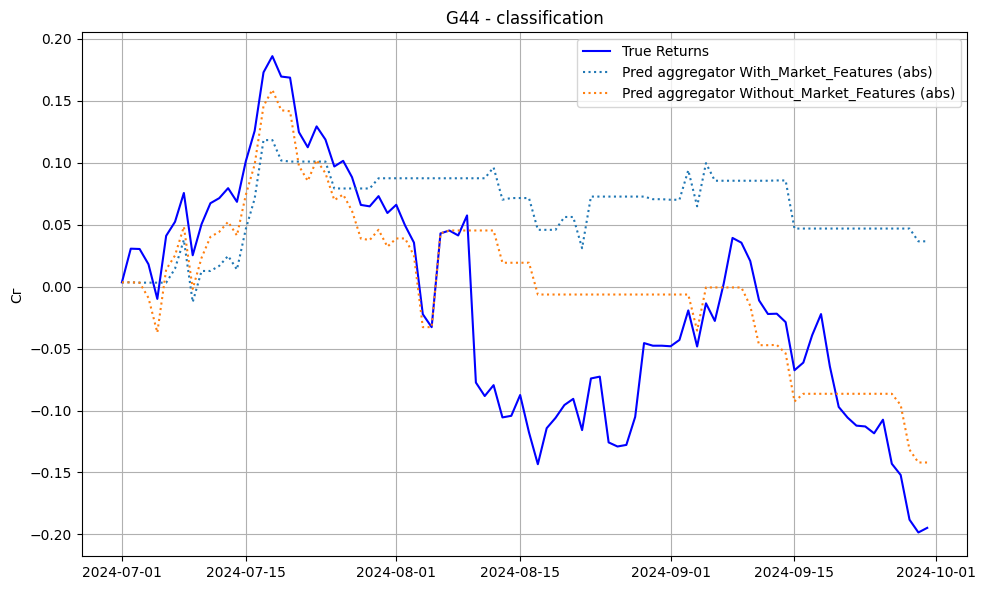

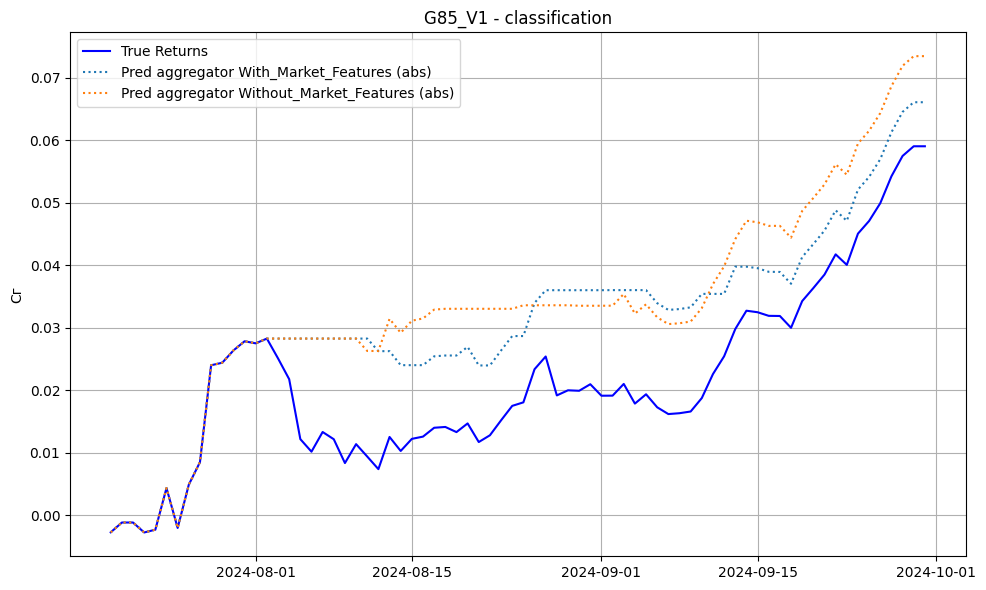

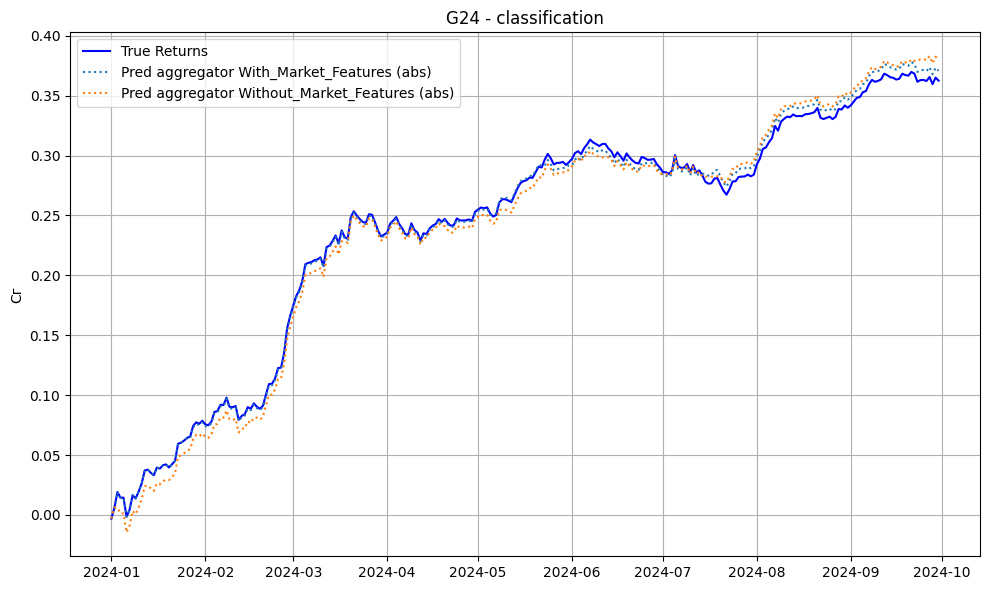

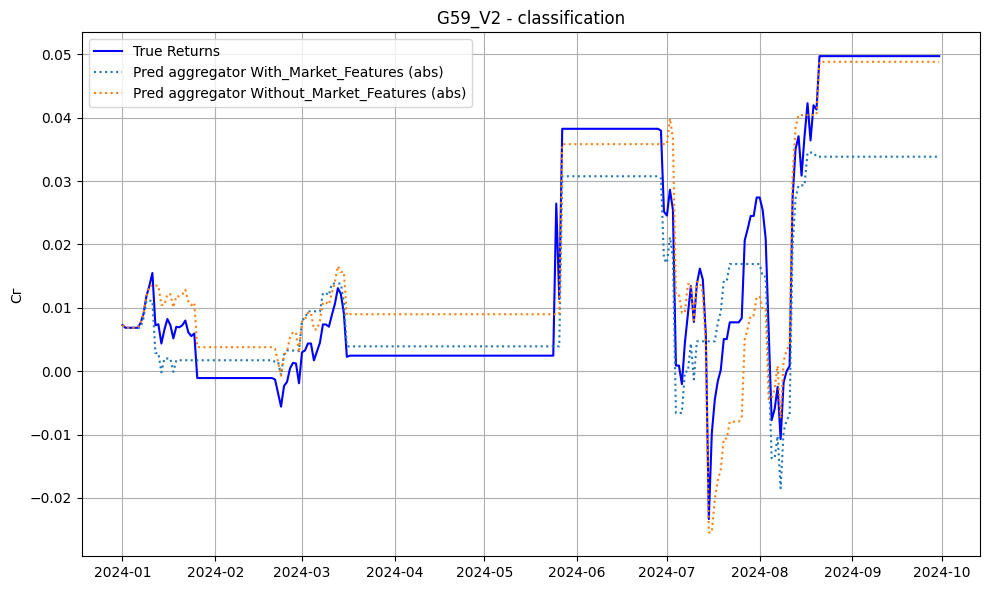

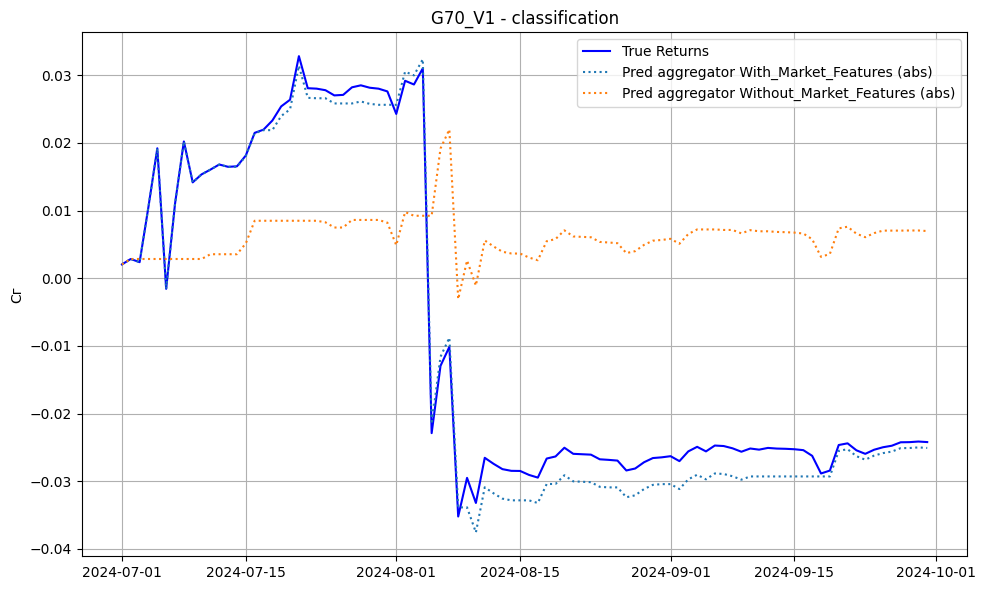

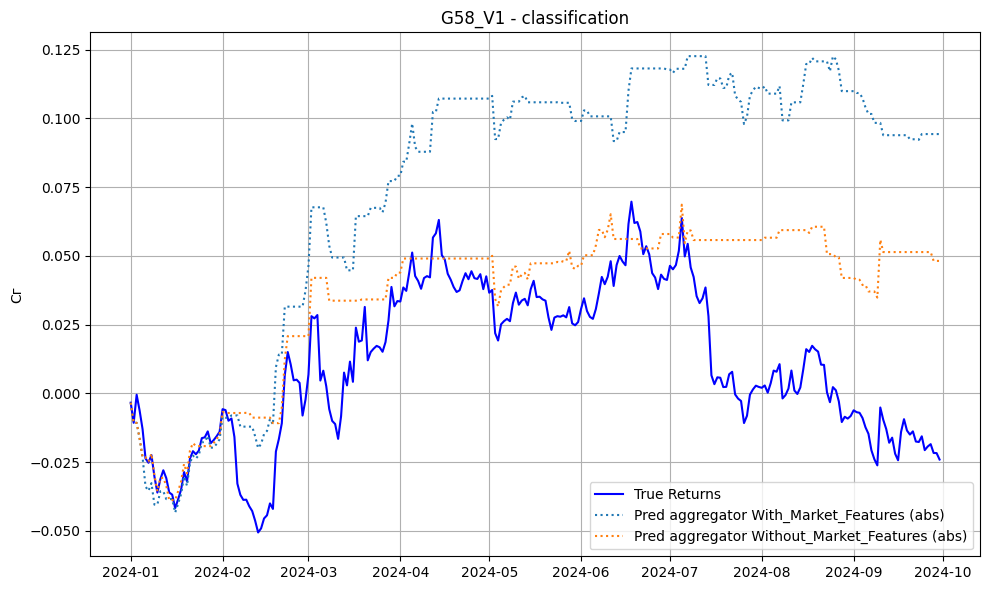

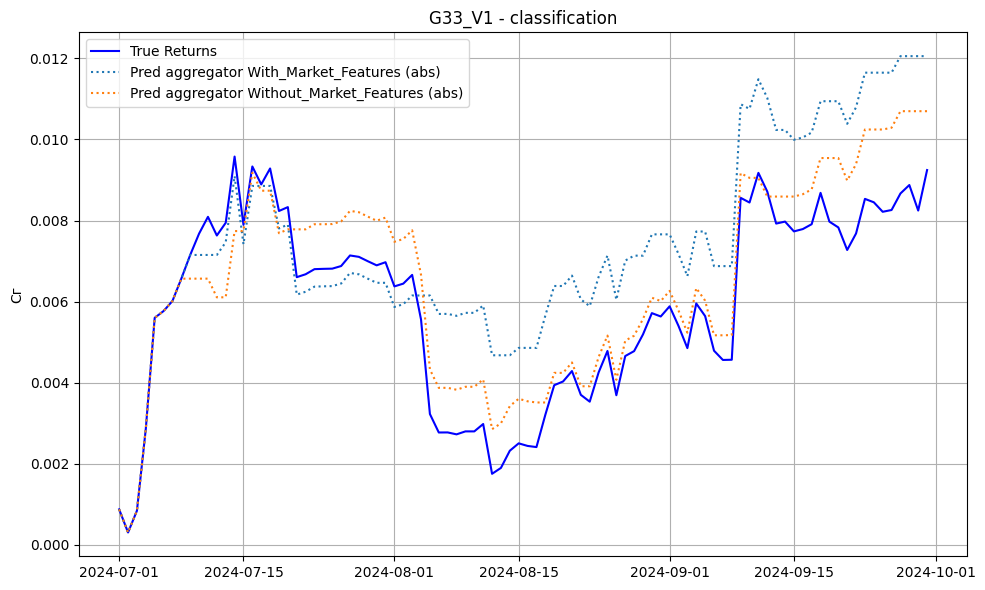

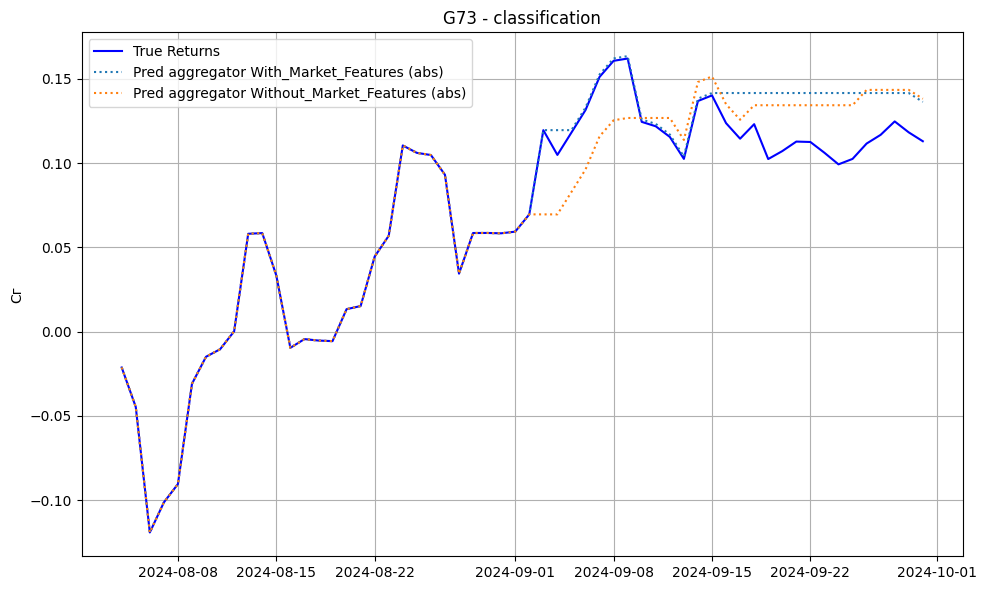

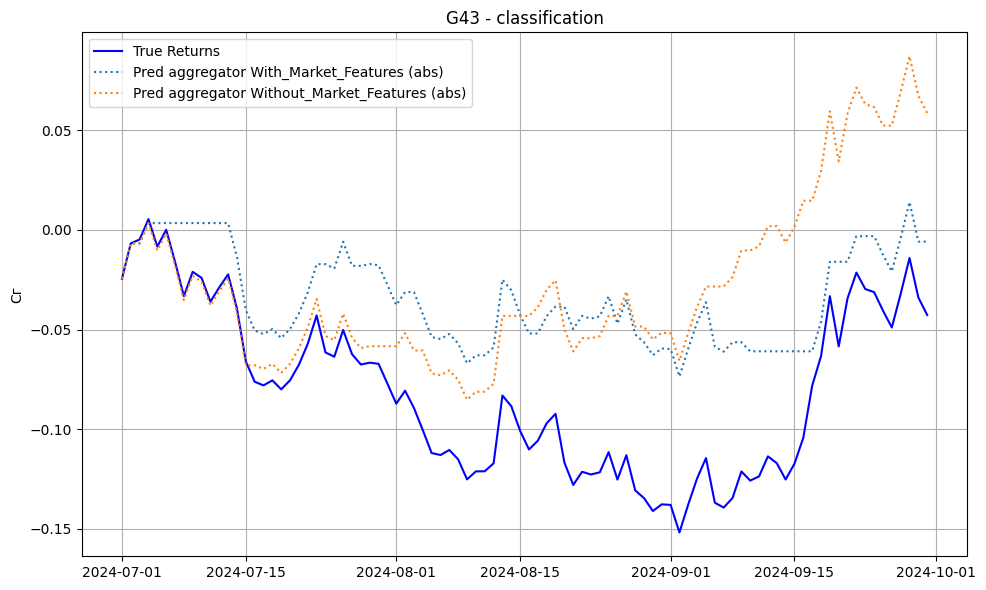

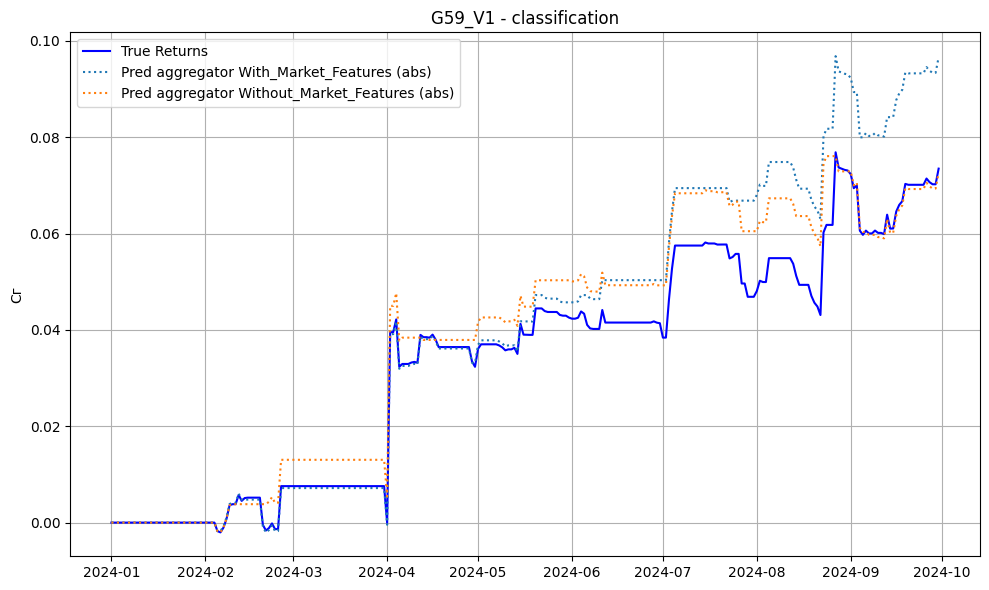

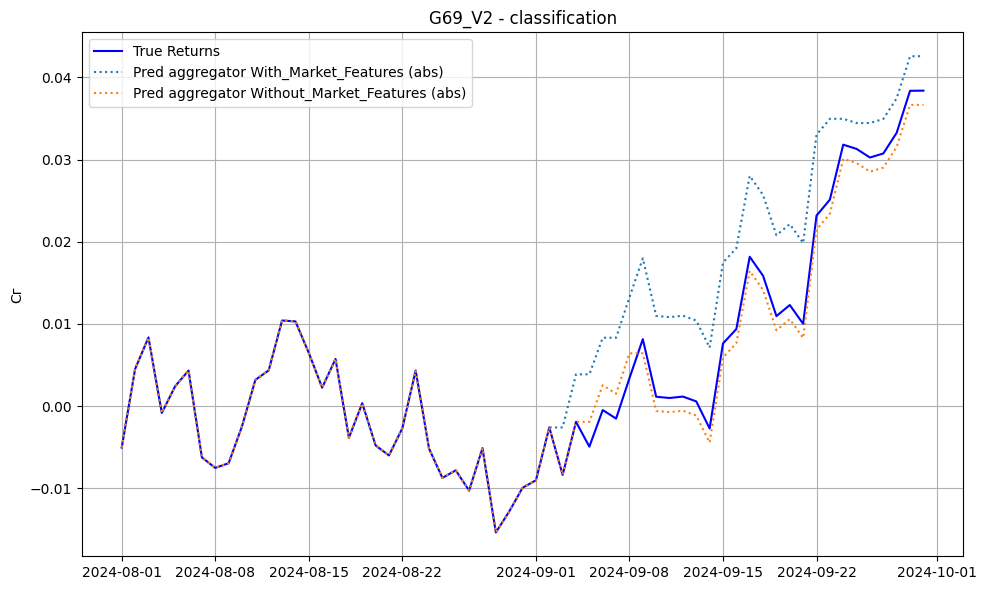

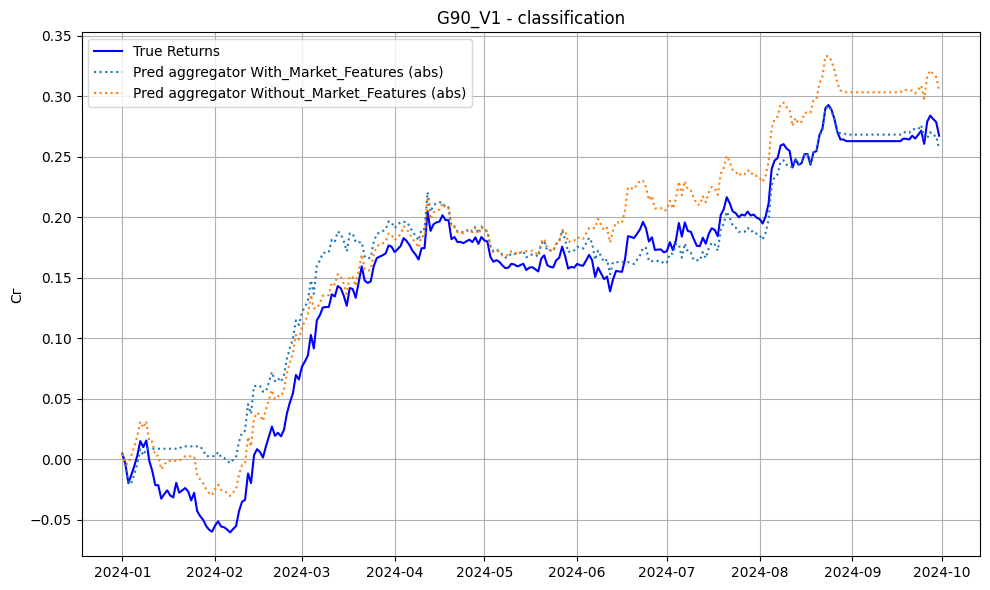

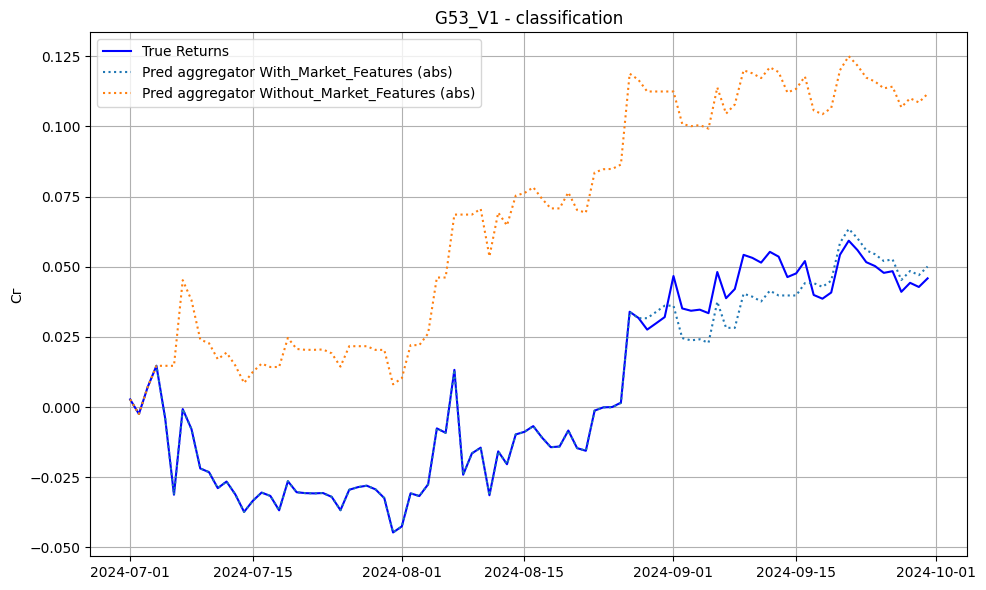

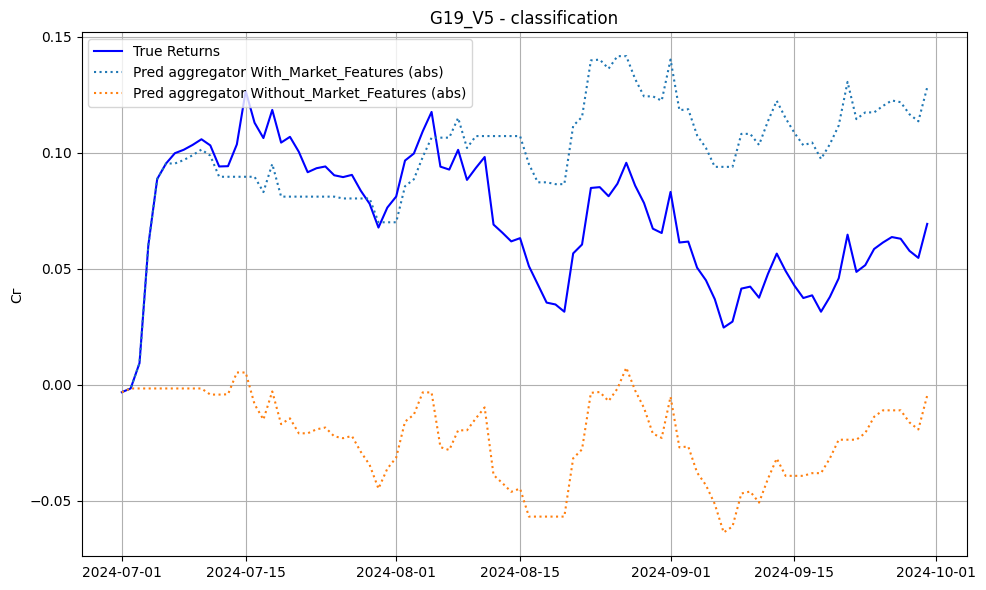

In [37]:
for strategy in strategies:
    plt.figure(figsize=(10, 6))
    for i, fs_name in enumerate(feature_sets.keys()):
        df = aggregator_predictions[strategy][fs_name].copy()
        if strategy in ["G59_V1", "G59_V2", "G90_V1", "G24", "G58_V1"]:
                    test_period = df.loc["2024"]
                    start = "2024-01-01"
        else:
            start = "2024-07-01"
            test_period = df.loc["2024-07-01":"2024-12-31"]

        cumulative_returns = test_period["Mean_Returns_1"].cumsum()
        
        agg_col_name = f"Preds_Aggregator_{aggregator_target}"
        
        if agg_col_name not in test_period.columns:
            print(
                f"Aggregator prediction {agg_col_name} not found for {strategy}. Skipping."
            )
            continue

        pred_zero_abs = test_period.loc[
                    test_period[agg_col_name] == 0
                ].index
            
        sim_returns = test_period["Mean_Returns_1"].copy()
        sim_returns[test_period[agg_col_name] < 0] = 0
        cumulative_sim = sim_returns.cumsum()

        if i == 0:
            plt.plot(
                test_period.index,
                cumulative_returns,
                label=f"True Returns",
                color="blue",
            )

        plt.plot(
            test_period.index,
            cumulative_sim,
            label=f"Pred aggregator {fs_name} (abs)",
            linestyle=":",
        )
    plt.title(f"{strategy} - classification")
    plt.ylabel(f"Сг")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"graph/ensemble_multi/{strategy}.png")
    plt.show()